In [ ]:
!python --version
import os
import warnings
print (os.environ['CONDA_DEFAULT_ENV'])

#suppress warnings
warnings.filterwarnings('ignore')

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

client

# 1. Workbook setups

## 1.1 Import packages

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import numpy.ma as ma
import xarray as xr
xr.set_options(file_cache_maxsize=10)


import seaborn as sns

import scipy as scipy
from scipy import stats
from scipy import signal
from scipy.integrate import trapz
import math
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit

from sklearn import linear_model, datasets
from sklearn import mixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error



from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn import preprocessing

# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# http://scikit-learn.org/stable/modules/mixture.html
from sklearn.mixture import GaussianMixture


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
import cmocean.cm as cmo


import proplot as plot
import cartopy.crs as ccrs

import shapefile as shp
from shapely.geometry import Point, Polygon
import shapely
from geopy.distance import distance, Distance, lonlat
import pygplates

from matplotlib import font_manager
font_manager.findfont("TeX Gyre Heros")
mpl.rcParams.update({'font.sans-serif':'TeX Gyre Heros',
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'pdf.fonttype':42,
                    'ps.fonttype':42
                     })

import string
import os
import requests
import io
from tqdm import tqdm
import time
import copernicusmarine
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit


## 1.2 Miscellaneous codes

In [3]:
def _woa_variable(variable):
    '''
    codes to generate woa urls modified from https://pyoceans.github.io/python-oceans/_modules/oceans/datasets.html
    variables:
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'dissolved_oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
        'AOU': 'A',
        "density":"I",
        'mld':"M"
   time_periods:
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
   resolutions:
    '5': ('5deg', '5d'),
    '1': ('1.00', '01'),
    '04': ('0.25', '04'),
        

    an=Objectively analyzed climatologies are the objectively interpolated mean fields 
    for oceanographic variables at standard depth levels for the World Ocean.
    mn=The statistical mean is the average of all unflagged interpolated values at each 
    standard depth level for each variable in each 1° square which contains at least one
    '''
    _VAR = {
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
        'AOU': 'A',
        "density":"I",
        'mld':"M02"
    }
    v = _VAR.get(variable)
    if not v:
        raise ValueError(
            f'Unrecognizable variable. Expected one of {list(_VAR.keys())}, got "{variable}".'
        )
    return v

def _woa_url(variable, time_period, resolution):
    # base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC' ## original link from the source code
    base2 = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/'

    v = _woa_variable(variable)
    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
        
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }
    
    pref = 'woa18'
    
    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)
        

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )
        
    if variable not in ['salinity', 'temperature','density','mld']:
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        dddd = 'all'
   
    else:
        if variable == 'mld':
            dddd = 'decav81B0'
        elif variable == "temperature":
            dddd = 'decav'
        else:
            dddd = 'all'
    
    
    url = (
        f'{base2}'
        f'{variable}/{dddd}/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )            
    return url

##### WOA23 Data base url loader #############
def _woa23_url(variable, time_period, resolution):
    # base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC' ## original link from the source code
    base_woa23 = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'

    v = _woa_variable(variable)
    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
        
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }
    
    pref = 'woa23'
    
    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)
        

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )
        
    if variable not in ['salinity', 'temperature','density','mld']:
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        dddd = 'all'
   
    else:
        if variable == 'mld':
            dddd = 'decav81B0'
        elif ((variable == "temperature") or (variable == "salinity")):
            dddd = 'decav'
        else:
            dddd = 'all'
    
    
    url = (
        f'{base_woa23}'
        f'{variable}/netcdf/{dddd}/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )            
    return url

def round_to_nearest_half_int(num):
    return round(num * 2) / 2

def getClosestPoint_fromLineString(LineString_input,point1):
    if "MultiLineString" in str(type(LineString_input)):
        multiLineString = LineString_input
        len_multiLineString = len(multiLineString.geoms)
        idxMin = np.array([multiLineString.geoms[i].distance(point1) for i in range(len_multiLineString)]).argmin()
        
        LineString = multiLineString.geoms[idxMin]
    elif "Polygon" in str(type(LineString_input)):
        
        polygon_input = LineString_input
        LineString = polygon_input.exterior
        
    else:
        LineString = LineString_input
        
    Coords = LineString.coords
    x, y = Coords.xy

    coords_df = pd.DataFrame({'LON':x,'LAT':y})
    coords_df['LAT_diff'] = abs(point1.y-coords_df.LAT)
    coords_df['LON_diff'] = abs(point1.x-coords_df.LON)
    coords_df['LONLAT_diff_sum'] = coords_df['LAT_diff']+coords_df['LON_diff']
    lat2,lon2 = coords_df.LAT.iloc[coords_df.LONLAT_diff_sum.idxmin()],coords_df.LON.iloc[coords_df.LONLAT_diff_sum.idxmin()]
    point2 = Point(lon2,lat2)
    return point2

def distance_haversine(origin, destination, output_unit='km'):
    import math
    lon1, lat1 = origin
    lon2, lat2 = destination
    
    if output_unit=='km':
        radius = 6371
    elif output_unit=='mi':
        radius = 3956
    elif output_unit=='m':
        radius = 6371000
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

def nonnan_gradient(array, axis=None, edge_order=1):
  """Computes the gradient of an array, ignoring NaN values.

  Args:
    array: An N-dimensional array containing samples of a scalar function.
    axis: The axis along which to compute the gradient. If None, the gradient
      is computed for all axes.
    edge_order: The order of the accuracy of the approximation at the edges of
      the array.

  Returns:
    An N-dimensional array or a list of N-dimensional arrays representing the
    gradient.
  """

  # Create a mask of non-NaN values.
  mask = np.isfinite(array)

  # Compute the gradient of the masked array.
  gradient = np.gradient(array, axis=axis, edge_order=edge_order)

  # Set the gradient to zero wherever the mask is False.
  for i in range(len(gradient)):
    gradient[i][~mask] = 0

  return gradient

## 1.3 Dictionaries

In [4]:
ringNumbers_dict_zhang16 = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':4, 
    'fGDGT_cren':4,
    'reported_1292_iso':4,
    'fGDGT_cren_prime':4,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

ringNumbers_dict_revised = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':5, 
    'fGDGT_cren':5,
    'reported_1292_iso':5,
    'fGDGT_cren_prime':5,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

def label_pvalues(x):
    if x<0.001:
        return r'$\it{p}$<.001'
    elif x<0.01:
        return r'$\it{p}$<.01'
    elif x<0.05:
        return r'$\it{p}$<.05'
    elif x<0.1:
        return r'$\it{p}$<.1'
    elif x>=0.1:
        return r'$\it{p}$>.1'


## 1.4 Set local paths

In [5]:
# set the path to local folder other than github

### 1.4.1 Local path on PC
local_documents_path = '/home/ronnie/Documents' ### this is the path when code is run on Linux

### 1.4.2 Path to github folder
gitpath_idx = os.getcwd().find('nutrient-effect-on-TEX')+len('nutrient-effect-on-TEX')
local_github_path = os.getcwd()[:gitpath_idx]

### 1.4.3 Path to OneDrive folder
local_onedrive_path = '/home/ronnie/OneDrive'

# 2. Import data

## 2.1 Processed coretop_df_full


In [6]:
local_github_path

'/home/ronnie/Documents/GitHub/nutrient-effect-on-TEX'

In [7]:
fpath = fr'{local_github_path}/spreadsheets'
fname = 'coretop_df_full_011525_tmp.csv'

coretop_df = pd.read_csv(f'{fpath}/{fname}')
coretop_df

,sampleID,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,fGDGT_0,...,thermocline_nitrate_depthIntegral,region_ID,regionName,TEX_RI_zhang16,deltaRI_zhang16,TEX_RI_new,deltaRI_new,QC_flag2,pred_tex,tex_residuals
0,TEXAS_PSM_RR00001,GeoB7702-3,GC,5.0,6.0,31.6517,34.0733,562.0,0.662000,NaN,...,0.025728,NaN,NaN,2.535230,NaN,2.671335,NaN,exclude,0.592688,0.069312
1,TEXAS_PSM_RR00002,KNR195-5 MC11,MC,6.0,8.0,-1.5327,-86.7852,2288.0,0.602873,0.330589,...,5.318187,10.0,East Equatorial Pacific,2.332461,-0.009145,2.490897,0.149291,include,0.602537,0.000336
2,TEXAS_PSM_RR00003,KNR195-5 MC12,MC,0.0,1.0,-3.7105,-81.1153,378.0,0.570000,NaN,...,4.208444,NaN,NaN,2.229768,NaN,2.390579,NaN,exclude,0.598017,-0.028017
3,TEXAS_PSM_RR00004,KNR195-5 MC16,MC,0.0,1.0,-3.7502,-81.1358,379.0,0.572000,NaN,...,5.378340,NaN,NaN,2.235811,NaN,2.396682,NaN,exclude,0.597470,-0.025470
4,TEXAS_PSM_RR00005,KNR195-5 MC18,MC,4.0,6.0,-3.9690,-81.3100,1024.0,0.599447,0.282415,...,4.969550,10.0,East Equatorial Pacific,2.321423,-0.245102,2.480441,-0.086083,include,0.589827,0.009620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,TEXAS_PSM_RR02077,SY201710_LD-18,NaN,NaN,NaN,20.5700,113.8000,89.0,0.595556,0.236000,...,0.170105,38.0,South China Sea,2.308981,-0.292019,2.468567,-0.132433,include,0.628749,-0.033194
2075,TEXAS_PSM_RR02078,DO201207-08_QD11a,NaN,NaN,NaN,20.7000,113.3700,81.0,0.512500,0.281000,...,0.258762,38.0,South China Sea,2.067394,-0.457606,2.215107,-0.309893,include,0.627801,-0.115301
2076,TEXAS_PSM_RR02079,DO201207-08_QD41,NaN,NaN,NaN,20.1400,112.0600,87.0,0.585859,0.236000,...,0.105737,38.0,South China Sea,2.278413,-0.373587,2.438974,-0.213026,include,0.636040,-0.050181
2077,TEXAS_PSM_RR02080,DO201207-08_E503,NaN,NaN,NaN,19.2000,112.2900,189.0,0.651376,0.237000,...,0.065285,38.0,South China Sea,2.497086,-0.149914,2.638914,-0.008086,include,0.642319,0.009058


In [8]:
import matplotlib.colors as mcolors
##### concatenate three colormaps

colors1 = plot.get_colors('tab10')
colors2 = plot.get_colors('tab20b')
colors3 = plot.get_colors('538')
colors4 = plot.get_colors('tab20c')
colors5 = plot.get_colors('bmh')

combined_cmap = np.concatenate((colors1,colors2,colors3,colors4,colors5))
extended_cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap',combined_cmap)
#########
region_list_full = coretop_df['regionName'].unique()
color_list_full = plot.get_colors(extended_cmap,len(region_list_full))

region_color_dict_full = dict(zip(region_list_full,color_list_full))
region_color_dict_full

region_color_dict_full_rgb = {k:mpl.colors.to_rgba(v) for k,v in region_color_dict_full.items()}
region_color_dict_full_rgb

{nan: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'East Equatorial Pacific': (0.984313725490196,
  0.5019607843137255,
  0.058823529411764705,
  1.0),
 'Mozambique Channel': (0.2, 0.6078431372549019, 0.17254901960784313, 1.0),
 'Pacific-Southern Ocean': (0.7568627450980392,
  0.23137254901960785,
  0.3411764705882353,
  1.0),
 'Tasman-Antarctica 140E Transect': (0.5686274509803921,
  0.3803921568627451,
  0.592156862745098,
  1.0),
 'NZ-SW Pacific': (0.6705882352941176,
  0.3843137254901961,
  0.4588235294117647,
  1.0),
 'Equatorial Pacific': (0.6431372549019608,
  0.48627450980392156,
  0.596078431372549,
  1.0),
 'West Equatorial Pacific': (0.6509803921568628,
  0.6549019607843137,
  0.2627450980392157,
  1.0),
 'Tonga-Tropical South Pacific': (0.3058823529411765,
  0.7450980392156863,
  0.5843137254901961,
  1.0),
 'South China Sea': (0.21568627450980393,
  0.2627450980392157,
  0.49411764705882355,
  1.0),
 'Chilean Offshore': (0.3176470588235294,
  0.3254

In [9]:
regionName_df = coretop_df.pivot_table(index=('region_ID','regionName'),values='TEX86',aggfunc='count').reset_index()[['region_ID','regionName']]
regionID_to_regionName_dict = dict(zip(regionName_df['region_ID'],regionName_df['regionName']))
regionID_to_regionName_dict


{1.0: 'Amundsen Sea',
 2.0: 'Arabian Sea',
 3.0: 'Arctic Ocean',
 4.0: 'Baltic Sea',
 5.0: 'Bering Sea',
 6.0: 'Black Sea',
 7.0: 'Chilean Offshore',
 8.0: 'Chukchi Sea',
 9.0: 'Drake Passage',
 10.0: 'East Equatorial Pacific',
 11.0: 'Eastern Indian Ocean (Offshore Indonesia)',
 12.0: 'Eastern North America Offshore',
 13.0: 'Eastern South America Offshore',
 14.0: 'Greenland Sea',
 15.0: 'Gulf of Aqaba',
 16.0: 'Gulf of California',
 17.0: 'Gulf of Mexico',
 18.0: 'Hudson Bay',
 19.0: 'Indian Ocean Gyre',
 20.0: 'Indonesian Throughflow',
 21.0: 'Japan Sea',
 22.0: 'Kara Sea',
 23.0: 'Laptev Sea',
 24.0: 'Mediterranean',
 25.0: 'Mozambique Channel',
 26.0: 'North Atlantic',
 27.0: 'North Sea',
 28.0: 'Northern Pacific',
 29.0: 'NZ-SW Pacific',
 30.0: 'Pacific-Southern Ocean',
 31.0: 'Red Sea',
 32.0: 'Ross Sea',
 33.0: 'Santa Barbara Bay',
 34.0: 'SE Pacific',
 35.0: 'Sea of Okhotsk',
 36.0: 'South Africa Offshore',
 37.0: 'South Atlantic Gyre',
 38.0: 'South China Sea',
 39.0: 'South

## 2.2 Ocean products

### 2.2.1 Temperature

In [10]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav91C0_t00_04.nc'),decode_times=False).drop('time')

T_da = ts.t_an
T_da

<xarray.DataArray 't_an' (time: 1, depth: 102, lat: 720, lon: 1440)>
[105753600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Dimensions without coordinates: time
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [11]:
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'
fname = 'WOA23_thermocline_depthIntegral_T_011625.nc'

thermocline_T_depthIntegral = xr.open_dataset(f'{fpath}/{fname}',decode_times=False).thermocl_depthIntg_T
thermocline_T_depthIntegral

<xarray.DataArray 'thermocl_depthIntg_T' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 ...

In [12]:
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'
fname = r'WOA23_thermocline_depth_011625.nc'

thermocline_depth_da = xr.open_dataarray(os.path.join(fpath,fname),decode_times=False)
thermocline_depth_da

<xarray.DataArray 'thermocl_depth' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    (lat, lon) float32 ...
Attributes:
    standard_name:  depth
    bounds:         depth_bnds
    positive:       down
    units:          meters
    axis:           Z

### 2.2.2 CMEMS Nitrate

In [13]:
### NEMO nitrate data
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/Marine-Copernicus-Service/processed-files/Global-Biogeochemistry/climo-monthly/no3'
fname = r'mercatorfreebiorys2v4_global_mean_ANN_199301_202212_climo.nc'

nitrate_CMEMS_ds = xr.open_dataset(os.path.join(fpath,fname))
nitrate_CMEMS_ds = nitrate_CMEMS_ds.rename({'latitude':'lat','longitude':'lon'}).drop('time')
nitrate_CMEMS_da = nitrate_CMEMS_ds.no3

depth_coord = nitrate_CMEMS_da.depth
depth_coord = depth_coord - depth_coord[0]
nitrate_CMEMS_da = nitrate_CMEMS_da.assign_coords(depth=depth_coord)
nitrate_CMEMS_da

<xarray.DataArray 'no3' (time: 1, depth: 75, lat: 681, lon: 1440)>
[73548000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -80.0 -79.75 -79.5 -79.25 ... 89.25 89.5 89.75 90.0
  * depth    (depth) float32 0.0 1.05 2.162 ... 5.494e+03 5.698e+03 5.902e+03
Dimensions without coordinates: time
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

In [14]:
### regrid nitrate_CMESM to T_an grid
nitrate_CMEMS_da_regrid_ll = nitrate_CMEMS_da.interp(lat=T_da.lat,lon=T_da.lon,method='linear')
display(nitrate_CMEMS_da_regrid_ll)

nitrate_CMEMS_da_regrid_lld = nitrate_CMEMS_da.interp(lat=T_da.lat,lon=T_da.lon,depth=T_da.depth,method='linear')
nitrate_CMEMS_da_regrid_lld

<xarray.DataArray 'no3' (time: 1, depth: 75, lat: 720, lon: 1440)>
array([[[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [5.7811136, 5.7841377, 5.7870884, ..., 5.771783 , 5.774918 ,
                nan],
         [5.749591 , 5.750575 , 5.751523 , ..., 5.7464533, 5.7475266,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.0 1.05 2.162 ... 5.494e+03 5.698e+03 5.902e+03
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Dimensions without coordinates: time
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

<xarray.DataArray 'no3' (time: 1, depth: 102, lat: 720, lon: 1440)>
array([[[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [5.7811136, 5.7841377, 5.7870884, ..., 5.771783 , 5.774918 ,
                nan],
         [5.749591 , 5.750575 , 5.751523 , ..., 5.7464533, 5.7475266,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Dimensions without coordinates: time
Attributes:
    long_name:      Nitrate
    standard_name:  mole_concentration_of_nitrate_in_sea_water
    units:          mmol m-3
    unit_long:      millimoles of Nitrate per cubic meter
    valid_min:      0.0
    valid_max:      59.31268
    cell_methods:   time: mean

In [15]:
### thermocline depthIntegral Nitrate
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties/'
fname = 'CMEMS_thermocline_nitrate_integral_011625.nc'

thermocline_nitrate_da = xr.open_dataset(os.path.join(fpath,fname)).thermocl_depthIntg_nitrate
thermocline_nitrate_da

<xarray.DataArray 'thermocl_depthIntg_nitrate' (time: 1, lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 ...
Dimensions without coordinates: time

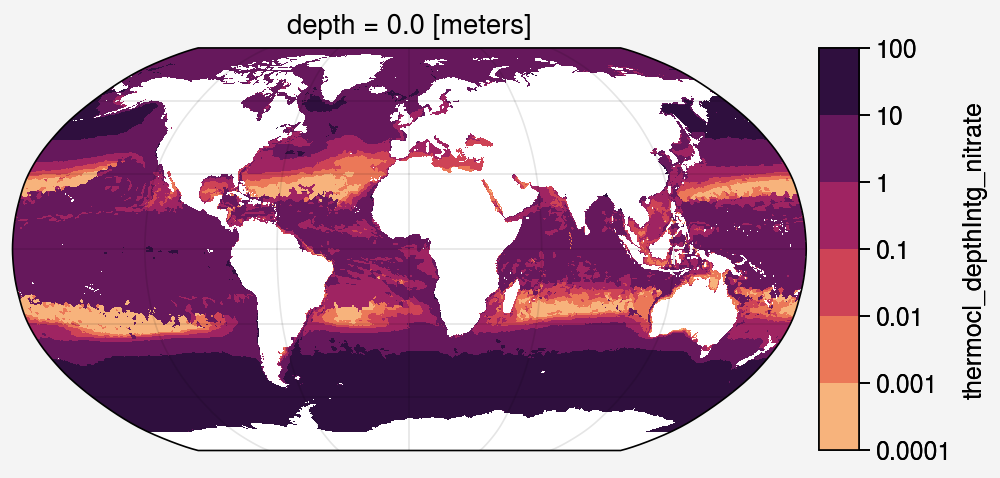

In [16]:
fig, axs = plot.subplots(proj='robin',width=5)

m = thermocline_nitrate_da.plot(ax=axs,
                                robust=True,
                                cmap='matter',
                                levels=[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2],
                                )

### 2.2.3 WOA23 Nitrate

In [17]:
### WOA23 nitrate
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
fname = r'woa23_all_n00_01.nc'

WOA23_nitrate_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).n_an
WOA23_nitrate_da

<xarray.DataArray 'n_an' (time: 1, depth: 102, lat: 180, lon: 360)>
[6609600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time     (time) float32 3.894e+03
Attributes:
    standard_name:  moles_of_nitrate_per_unit_mass_in_sea_water
    long_name:      Objectively analyzed mean fields for moles_of_nitrate_per...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          micromoles_per_kilogram

In [18]:
### WOA23 thermocline depthIntegral nitrate
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'
fname = r'WOA23_thermocline_nitrate_integral_011625.nc'

WOA23_thermocline_nitrate_da = xr.open_dataarray(os.path.join(fpath,fname),decode_times=False)
WOA23_thermocline_nitrate_da

<xarray.DataArray 'thermocl_depthIntg_nitrate' (time: 1, lat: 180, lon: 360)>
[64800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    depth    float32 ...
  * time     (time) float32 3.894e+03

## 2.3 Gridded TEX

In [19]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'coretop_gridded_ds_012225_QCflag1.nc'
gridded_coretop_ds = xr.open_dataset(os.path.join(fpath,fname))
gridded_coretop_ds

<xarray.Dataset>
Dimensions:                      (lat: 720, lon: 1440)
Coordinates:
  * lat                          (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                          (lon) float32 -179.9 -179.6 ... 179.6 179.9
Data variables: (12/16)
    sst                          (lat, lon) float32 ...
    ssn                          (lat, lon) float32 ...
    thermocline_depth            (lat, lon) float32 ...
    thermocl_T                   (lat, lon) float32 ...
    thermocl_depthIntg_T         (lat, lon) float32 ...
    thermocl_nitrate             (lat, lon) float32 ...
    ...                           ...
    thermocline_T_depthIntegral  (lon, lat) float32 ...
    tex_count                    (lon, lat) float64 ...
    tex_median                   (lon, lat) float64 ...
    tex_mean                     (lon, lat) float64 ...
    tex_std                      (lon, lat) float64 ...
    tex_residuals                (lon, lat) float64 ...
Attributes:
    standard_name:  gridded coretop TEX86 data
    long_name:      median value of TEX86 for each grid cell with the same la...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          TEX86 [unitless], SST [degC], SSN [umol/L], depth [m], ni...
    source:         This Study

## 2.4 Gridded amOxRate data

In [20]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'gridded_AOM_ds_011825.nc'
merged_ammOxR_gridded_ds = xr.open_dataset(os.path.join(fpath,fname))
merged_ammOxR_gridded_ds

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, depth: 55)
Coordinates:
  * lat                   (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                   (lon) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * depth                 (depth) float32 0.0 5.0 10.0 ... 2.5e+03 3e+03 3.5e+03
Data variables: (12/29)
    ammoniaOxidationRate  (lat, lon, depth) float64 ...
    NH4_uM                (lat, lon, depth) float64 ...
    NO2_uM                (lat, lon, depth) float64 ...
    NO3_uM                (lat, lon, depth) float64 ...
    ammOxRate_count       (lat, lon, depth) float64 ...
    ammOxRate_median      (lat, lon, depth) float64 ...
    ...                    ...
    NO3_median            (lat, lon, depth) float64 ...
    NO3_mean              (lat, lon, depth) float64 ...
    NO3_std               (lat, lon, depth) float64 ...
    NO3_min               (lat, lon, depth) float64 ...
    NO3_max               (lat, lon, depth) float64 ...
    SST                   (lat, lon) float32 ...

### Coretop data

In [21]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = r'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOA_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='ammonia oxidizer')
global_AOA_df = global_AOA_df.rename(
    columns={
        'Depth (m)': 'Depth',
        'shallow clade AOA (copies L-1)': 'shallow_clade_AOA_copiesL', 
        'deep clade AOA (copies L-1)': 'deep_clade_AOA_copiesL',
        'total AOA (copies L-1)': 'total_AOA_copiesL', 
        'Thaumarchaeota 16S rRNA (copies L-1)': 'Thaum_16S_rRNA_copiesL',
        ' βAOB (copies L-1)': 'beta_AOB_copiesL', 
        'shallow clade AOA transcript (copies L-1)': 'shallow_clade_AOA_transcript_copiesL',
        'deep clade AOA transcript (copies L-1)': 'deep_clade_AOA_transcript_copiesL',
        'total AOA transcript (copies L-1)': 'total_AOA_transcript_copiesL', 
        ' βAOB transcript (copies L-1)': 'beta_AOB_transcript_copiesL',
        'PAR (μmol Einstein m-2 s-1)': 'PAR', 
        'Light level (%)': 'light_level', 
        'Temperature (°C)': 'insituT',
        'Salinity (psu)': 'insituS', 
        'Potential density (kg m-3)': 'insituSigmaT', 
        'Ammonium+ammonia (μM)': 'NH4_uM',
        'Nitrite (μM)': 'NO2_uM', 
        'Nitrate (μM)': 'NO3_uM', 
        'O2 (μM)': 'insituOxy'}
    )
global_AOA_df

,Data source,data_source,Date,Latitude,Longitude,Depth,shallow_clade_AOA_copiesL,deep_clade_AOA_copiesL,total_AOA_copiesL,Thaum_16S_rRNA_copiesL,...,PAR,light_level,insituT,insituS,insituSigmaT,NH4_uM,NO2_uM,NO3_uM,pH,insituOxy
0,"Agogue et al., 2008. Nature","Agogue et al., 2008",2002 September,61.63,-20.82,2071.0,2360000,NaN,NaN,78400000,...,NaN,NaN,2.416,34.983,27.924,NaN,NaN,NaN,NaN,292.3
1,"Agogue et al., 2008. Nature","Agogue et al., 2008",2002 September,61.63,-20.82,1633.0,498000.0,NaN,NaN,13900000.0,...,NaN,NaN,3.263,34.952,27.822,NaN,NaN,NaN,NaN,287.4
2,"Agogue et al., 2008. Nature","Agogue et al., 2008",2002 September,61.63,-20.82,1014.0,2390000,NaN,NaN,135000000,...,NaN,NaN,5.552,35.065,27.660,NaN,NaN,NaN,NaN,247.8
3,"Agogue et al., 2008. Nature","Agogue et al., 2008",2002 September,61.63,-20.82,498.0,4680000,NaN,NaN,39900000,...,NaN,NaN,7.825,35.196,27.455,NaN,NaN,NaN,NaN,265.9
4,"Agogue et al., 2008. Nature","Agogue et al., 2008",2002 September,61.63,-20.82,99.0,7080000,NaN,NaN,63100000.0,...,NaN,NaN,9.089,35.228,27.283,NaN,NaN,NaN,NaN,264.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,"Zhang et al., 2020. PNAS.","Zhang et al., 2020",2015 April,30.00,147.00,500.0,NaN,NaN,623000,969342.7681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2245,"Zhang et al., 2020. PNAS.","Zhang et al., 2020",2015 April,30.00,147.00,650.0,NaN,NaN,1620000,2356267.472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2246,"Zhang et al., 2020. PNAS.","Zhang et al., 2020",2015 April,30.00,147.00,750.0,NaN,NaN,1460000,3740288.1866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2247,"Zhang et al., 2020. PNAS.","Zhang et al., 2020",2015 April,30.00,147.00,800.0,NaN,NaN,1360000,2532082.0546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = r'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOM_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='volumetric ammonia oxidation')
global_AOM_df = global_AOM_df.rename(
    columns={
        'Depth (m)':'Depth',
        'Rate (nmol N L-1 d-1)':'ammoniaOxidationRate', 
        'Standard deviation of rate (nmol N L-1 d-1)':'AOR_std',
        'PAR (μmol Einstein m-2 s-1)':'PAR',
        'Light level (%)':'light_level',
        'Temperature (°C)':'insituT',
        'Salinity (psu)':'insituS',
        'Potential density (kg m-3)':'insituSigmaT',
        'Ammonium+ammonia (μM)':'NH4_uM',
        'Nitrite (μM)':'NO2_uM',
        'Nitrate (μM)':'NO3_uM',
        'O2 (μM)':'insituOxy'}
    )
global_AOM_df = global_AOM_df.replace(
    {'NM':np.nan,
     'BDL':np.nan,}
)

In [23]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = 'revised_cultures_GDGT_github_RR2024.xlsx'
culture_df = pd.read_excel(os.path.join(fpath,fname),sheet_name="master_cultures")

features = ['reported_1302',
       'reported_1300', 'reported_1298', 'reported_1296', 'reported_1292',
       'reported_1292_iso', 'reported_1294', 'reported_1290', 'reported_1288',
       'reported_1286', 'reported_1292_iso2', 'reported_1294_iso',
       'reported_1290_iso', 'reported_1288_iso', 'reported_1286_iso'
       ]

culture_df[features] = culture_df[features].fillna(0)
culture_df['TEX86'] = culture_df[['reported_1298', 'reported_1296','reported_1292_iso']].sum(axis=1)/culture_df[['reported_1300','reported_1298', 'reported_1296','reported_1292_iso']].sum(axis=1)


features = ['reported_1302','reported_1300', 'reported_1298', 'reported_1296', 'reported_1292','reported_1292_iso']
culture_df['RI_zhang16'] = np.array([(culture_df[features[i]]/culture_df[features].sum(axis=1))*ringNumbers_dict_zhang16.get(features[i]) for i in range(len(features))]).sum(axis=0)
culture_df['scaledRI'] = culture_df['RI_zhang16']/4
culture_df['RI_zhang16_revised'] = np.array([(culture_df[features[i]]/culture_df[features].sum(axis=1))*ringNumbers_dict_revised.get(features[i]) for i in range(len(features))]).sum(axis=0)

features = ['reported_1302','reported_1300', 'reported_1298', 'reported_1296','reported_1294','reported_1294_iso','reported_1292','reported_1292_iso']
culture_df['RI_0to5'] = np.array([(culture_df[features[i]]/culture_df[features].sum(axis=1))*ringNumbers_dict_revised.get(features[i]) for i in range(len(features))]).sum(axis=0)

features = ['reported_1302','reported_1300', 'reported_1298', 'reported_1296', 'reported_1292',
       'reported_1292_iso', 'reported_1294', 'reported_1290', 'reported_1288',
       'reported_1286', 'reported_1292_iso2', 'reported_1294_iso',
       'reported_1290_iso', 'reported_1288_iso', 'reported_1286_iso']
culture_df['ringIndex_0to8'] = np.array([(culture_df[features[i]]/culture_df[features].sum(axis=1))*ringNumbers_dict_revised.get(features[i]) for i in range(len(features))]).sum(axis=0)

features = ['reported_1302',
       'reported_1300', 'reported_1298', 'reported_1296', 'reported_1292',
       'reported_1292_iso', 'reported_1294', 'reported_1290',
       'reported_1292_iso2', 'reported_1294_iso','reported_1290_iso',]
culture_df['ringIndex_0to6'] = np.array([(culture_df[features[i]]/culture_df[features].sum(axis=1))*ringNumbers_dict_revised.get(features[i]) for i in range(len(features))]).sum(axis=0)
culture_df['gdgt23ratio'] = culture_df['reported_1298']/culture_df['reported_1296']
culture_df['methaneIndex'] = culture_df[['reported_1300', 'reported_1298', 'reported_1296']].sum(axis=1)/culture_df[['reported_1300', 'reported_1298', 'reported_1296','reported_1292','reported_1292_iso']].sum(axis=1)
culture_df['gdgtZeroOverZeroCren'] = (culture_df['reported_1302']/culture_df[['reported_1302','reported_1292']].sum(axis=1))*100

new_params_check = ['RI_zhang16','RI_zhang16_revised','RI_0to5','ringIndex_0to8','ringIndex_0to6','gdgt23ratio','methaneIndex','gdgtZeroOverZeroCren']

AOR_culture_df = culture_df[culture_df['Source']=='Hurley et al. (2016) PNAS'].reset_index(drop=True)
AOR_culture_df['reported_AOR_nmol_NO2_l_d'] = AOR_culture_df['reported_AOR_umol_NO2_l_d']*1000
AOR_culture_df


,sampleName,Strains,organism_reported_names,phyloT_order,GTDB_phylum,GTDB_class,GTDB_order,GTDB_family,GTDB_genus,GTDB_species,...,RI_zhang16,scaledRI,RI_zhang16_revised,RI_0to5,ringIndex_0to8,ringIndex_0to6,gdgt23ratio,methaneIndex,gdgtZeroOverZeroCren,reported_AOR_nmol_NO2_l_d
0,Hurley2016_N. maritimus SCM1_T28_pH7.6_slowGro...,SCM1,Nitrosopumilus maritimus SCM1,7.0,p__Thermoproteota,c__Nitrososphaeria,o__Nitrososphaerales,f__Nitrosopumilaceae,g__Nitrosopumilus,s__Nitrosopumilus maritimus,...,2.905263,0.726316,3.452632,3.452632,3.452632,3.452632,2.857143,0.395349,15.000000,31200.0
1,Hurley2016_N. maritimus SCM1_T28_pH7.6_interme...,SCM1,Nitrosopumilus maritimus SCM1,7.0,p__Thermoproteota,c__Nitrososphaeria,o__Nitrososphaerales,f__Nitrosopumilaceae,g__Nitrosopumilus,s__Nitrosopumilus maritimus,...,2.621053,0.655263,3.094737,3.094737,3.094737,3.094737,2.125000,0.444444,24.137931,71400.0
2,Hurley2016_N. maritimus SCM1_T28_pH7.6_fastGro...,SCM1,Nitrosopumilus maritimus SCM1,7.0,p__Thermoproteota,c__Nitrososphaeria,o__Nitrososphaerales,f__Nitrosopumilaceae,g__Nitrosopumilus,s__Nitrosopumilus maritimus,...,2.563830,0.640957,3.031915,3.031915,3.031915,3.031915,1.875000,0.435897,27.118644,101600.0


In [24]:
global_AOM_df['thermocline_depth'] = np.nan

for i in range(len(global_AOM_df)):
    lookup_lat = global_AOM_df['Latitude'][i]
    lookup_lon = global_AOM_df['Longitude'][i]
    
    try:
        thermocline_depth_tmp = thermocline_depth_da.sel(lat=lookup_lat,lon=lookup_lon,method='nearest').values
        global_AOM_df['thermocline_depth'][i] = thermocline_depth_tmp
        
    except:
        continue
    

In [25]:
global_AOM_df['thermocline_depth_position'] = global_AOM_df['Depth']-global_AOM_df['thermocline_depth']

# 3. Figures for main text

## Fig. 1: nitrate and ammonium conc. vs ammonia oxidation rate

In [26]:
plot_data_ammOx_nh4 = merged_ammOxR_gridded_ds.where(
    merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[
        ['ammOxRate_median','NH4_median',
        'ammOxRate_mean','NH4_mean']].to_dataframe().dropna().reset_index()
    
plot_data_ammOx_no3 = merged_ammOxR_gridded_ds.where(
    merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[[
        'ammOxRate_median','NO3_median',
        'ammOxRate_mean','NO3_mean']].to_dataframe().dropna().reset_index()
    
# plot_data_ammOx_no2 = merged_ammOxR_gridded_ds.where(
#     merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[
#         ['ammOxRate_median','NO2_median',
#         'ammOxRate_mean','NO2_mean']].to_dataframe().dropna().reset_index()

In [27]:
plot_data_only_ammOx = merged_ammOxR_gridded_ds.where(merged_ammOxR_gridded_ds.depth<=thermocline_depth_da)[['ammOxRate_median','ammOxRate_mean']].to_dataframe().dropna().reset_index()

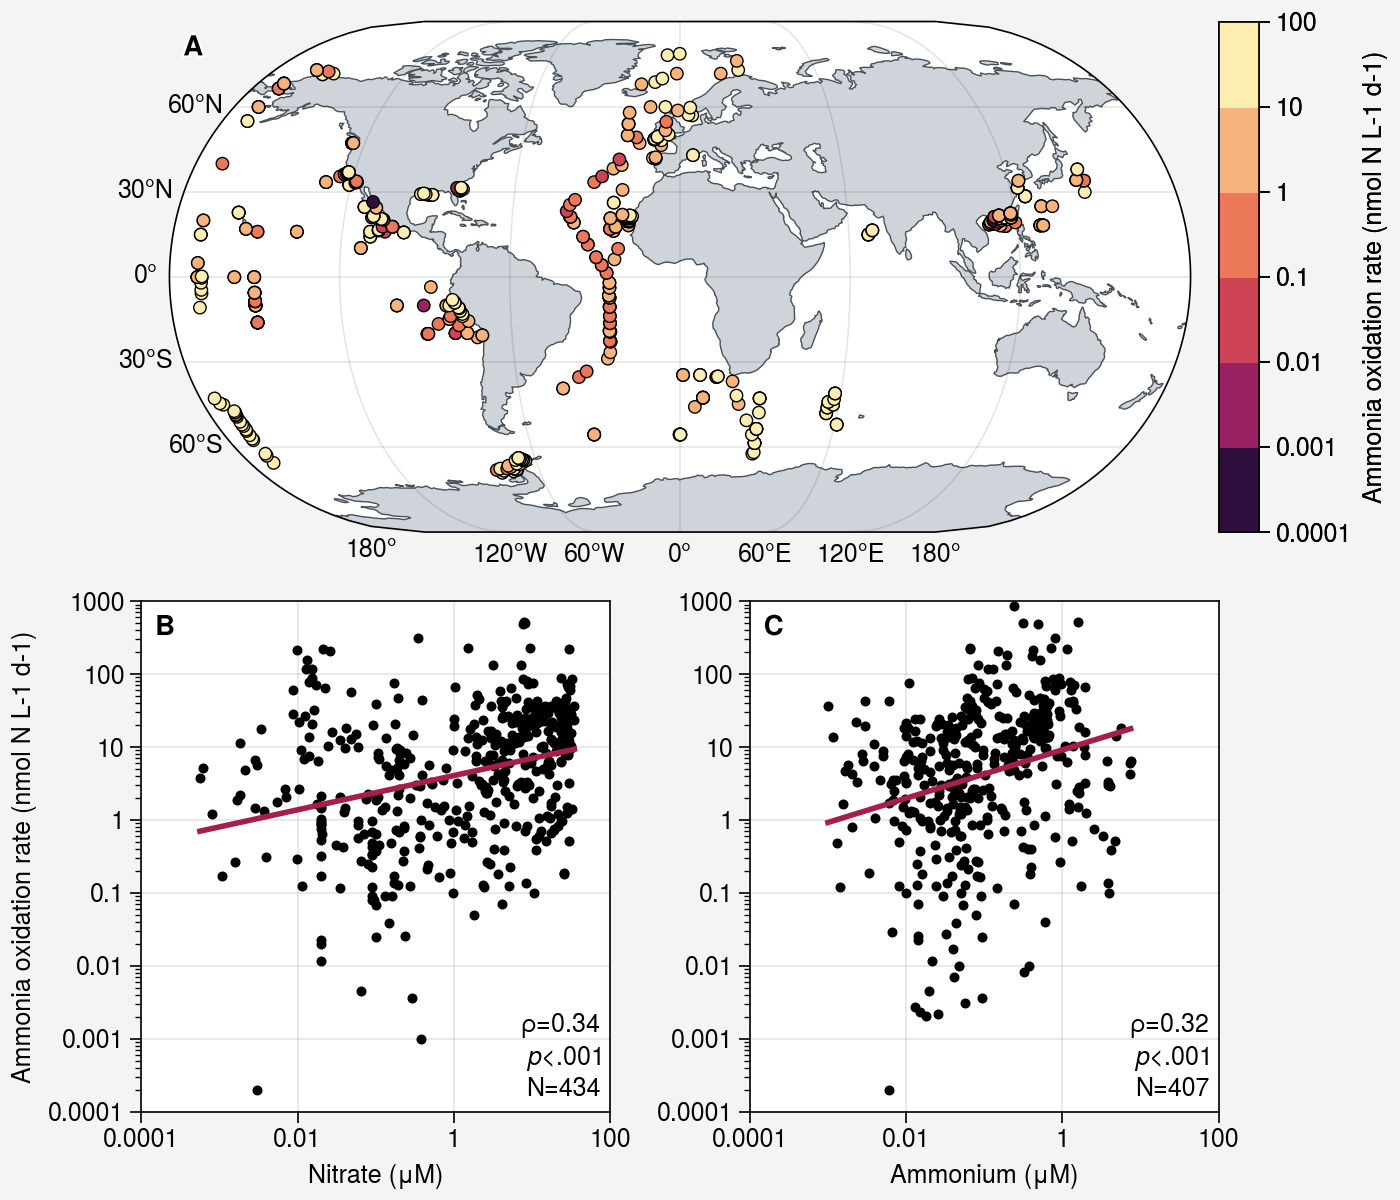

In [28]:
array = [
    [1,1],
    [2,3],
]

fig, axs = plot.subplots(array,proj=('eck3',None),
                         figsize=(7,6),share=False)

ax = axs[0]
ax.format(land=True, landcolor='gray4',landzorder=0,
          coast=True, coastcolor='gray7',coastlinewidth=0.5,coastzorder=1,
          latlabels=True, lonlabels=True)

plot_data = plot_data_only_ammOx
plot_x = plot_data['lon']
plot_y = plot_data['lat']
plot_c = plot_data['ammOxRate_median']
m = ax.scatter(plot_x,plot_y,
              c=plot_c,cmap='cmo.matter_r',
              levels=[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2],
              s=20,mec='k',mew=0.5,
              zorder=2)
ax.colorbar(m,label='Ammonia oxidation rate (nmol N L-1 d-1)')

plot_data_list = [plot_data_ammOx_no3,plot_data_ammOx_nh4]
plot_x_list = ['NO3_median','NH4_median']
plot_y_list = ['ammOxRate_median','ammOxRate_median']
for i, (plot_data,plot_x,plot_y) in enumerate(zip(plot_data_list,plot_x_list,plot_y_list)):
    
    ax = axs[1,i]
    ax.scatter(plot_data[plot_x],plot_data[plot_y],m='.',c='k')

    ### calculate log10 for plot_x and plot_y
    plot_data['Log10_'+plot_x] = np.log10(plot_data[plot_x])
    plot_data['Log10_'+plot_y] = np.log10(plot_data[plot_y])
    plot_data[['Log10_'+plot_x,'Log10_'+plot_y]] = plot_data[['Log10_'+plot_x,'Log10_'+plot_y]
                                                             ].replace([np.inf,-np.inf],np.nan)
    plot_data = plot_data.dropna(subset=['Log10_'+plot_x,'Log10_'+plot_y]).reset_index(drop=True)
    
    # ### orthoganal distance regression
    # X = plot_data['Log10_'+plot_x]
    # y = plot_data['Log10_'+plot_y]
    # odr_dat = scipy.odr.Data(X,y)
    # linear_func = lambda beta,x: beta[0]*x + beta[1]
    # odr_func = scipy.odr.Model(linear_func)
    # odr = scipy.odr.ODR(odr_dat,odr_func,beta0=[1.,0.])
    # out = odr.run()
    # slope = out.beta[0]
    # intercept = out.beta[1]
    # X_pred = np.linspace(X.min(),X.max(),100)
    # y_pred = linear_func(out.beta,X_pred)
    # ax.plot(10**X_pred,10**y_pred,c='k',ls='--',lw=2,label='ODR fit')

    # ### calculate score and pval for odr fit
    # # degree of freedom = len(plot_data)-2
    # degFree = len(plot_data)-2
    # beta_0 = 0
    # t_stat = out.beta[0]-beta_0/out.sd_beta[0]
    # pval = stats.t.sf(abs(t_stat),degFree)*2
    # print(pval)
    # pval_label = label_pvalues(pval)

    # ax.text(0.98,0.02,
    #         f't={t_stat:.2f}\n{pval_label}\nN={len(plot_data)}',
    #         transform=ax.transAxes,
    #         ha='right',va='bottom')
            
    ### ols fit
    ols = LinearRegression()
    X = plot_data['Log10_'+plot_x].values.reshape(-1,1)
    y = plot_data['Log10_'+plot_y]
    ols.fit(X,y)
    slope = ols.coef_[0]
    intercept = ols.intercept_
    X_pred = np.linspace(X.min(),X.max(),100)
    y_pred = ols.predict(X_pred.reshape(-1,1))
    ax.plot(10**X_pred,10**y_pred,c='pink9',lw=2,label='Linear fit')
    ### rho and p-value
    rho,pval = scipy.stats.spearmanr(X,y)
    pval_label = label_pvalues(pval)
    ax.text(0.98,0.02,
            f'$\\rho$={rho:.2f}\n{pval_label}\nN={len(plot_data)}',
            transform=ax.transAxes,
            ha='right',va='bottom')

axs[1,0].format(
    ylabel='Ammonia oxidation rate (nmol N L-1 d-1)',
    xlabel='Nitrate (μM)',
    xscale='log',
    yscale='log',
    xlim=(1e-4,1e2),
    ylim=(1e-4,1e3),
)

axs[1,0].format(
    ylabel='Ammonia oxidation rate (nmol N L-1 d-1)',
    xlabel='Nitrate (μM)',
    xscale='log',
    yscale='log',
    xlim=(1e-4,1e2),
    ylim=(1e-4,1e3),
)

axs[1,1].format(
    ylabel='',
    xlabel='Ammonium (μM)',
    xscale='log',
    yscale='log',
    xlim=(1e-4,1e2),
    ylim=(1e-4,1e3),
)
    
axs.format(
    abc=True,abcloc='ul',abcstyle='A'
)

fpath = fr'{local_github_path}/figures/'
fname = 'gridded_AOR_nitrate_ammonium.pdf'
fig.savefig(os.path.join(fpath,fname),dpi=300,bb_inches='tight')

## Fig. 2: Coretop TEX residuals

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def running_mean_log10(x, y, window_size):
        # Convert x to log10 scale
        log_x = np.log10(x)
        
        # Create a DataFrame with log_x and y
        df = pd.DataFrame({'log_x': log_x, 'y': y})
        
        # Sort the DataFrame by log_x
        df = df.sort_values(by='log_x')
        
        # Calculate the running mean of y with the specified window size
        df['y_running_mean'] = df['y'].rolling(window=window_size, center=True).mean()
        
        return df['log_x'], df['y_running_mean']

plot_coretop = gridded_coretop_ds[['thermocl_depthIntg_T','thermocl_depthIntg_nitrate',
                                   'tex_median','tex_std',
                                   'tex_residuals']].to_dataframe().reset_index()

exclude_coretop = coretop_df[coretop_df['QC_flag']=='exclude']
array = [
    [1,2],
    [3,3]
]
projs = (None,None,'eck3')
fig, axs = plot.subplots(array,proj=projs,
                         figsize=(8,8),
                         share=False,\
                         )


ax = axs[2]
ax.format(land=True, landcolor='gray4',landzorder=0,
          coast=True, coastcolor='gray7',coastlinewidth=0.5,coastzorder=1,
           title='Coretop TEX$_{86}$ residuals')
plot_data = plot_coretop[plot_coretop['lat']>70][['lon','lat','tex_median']].dropna(subset=['tex_median'])
plot_x = plot_data['lon']
plot_y = plot_data['lat']
ax.scatter(plot_x,plot_y,
           m='o',mec='gray7',facecolor='none',zorder=2,
           label='Excluded data')

plot_x = exclude_coretop['Longitude']
plot_y = exclude_coretop['Latitude']
ax.scatter(plot_x,plot_y,m='o',mec='gray7',facecolor='none',zorder=2)

plot_data = plot_coretop[plot_coretop['lat']<70][['lon','lat','tex_residuals']].dropna()
plot_x = plot_data['lon']
plot_y = plot_data['lat']
plot_c = plot_data['tex_residuals']
m=ax.scatter(plot_x,plot_y,
           c=plot_c,mec='k',
           levels=np.arange(-0.3,0.31,0.05),
           transform=ccrs.PlateCarree(),
           m='o',cmap='Balance',
           zorder=3)

axins1 = inset_axes(
    ax,
    width="50%",
    height="10%",
    loc="lower right",
    bbox_to_anchor=(-0.01,-0.05,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             label='TEX$_{86}$ residuals'
             )


#########################################################################################
ax = axs[0]
ax.format(
    xlabel='Thermocline-integrated temperature (\N{DEGREE SIGN}C)',
    ylabel='TEX$_{86}$'
)
plot_data = plot_coretop[plot_coretop['lat']<70][['thermocl_depthIntg_T',
                                                  'tex_median']].dropna().reset_index(drop=True)
plot_x = plot_data['thermocl_depthIntg_T']
plot_y = plot_data['tex_median']
ax.scatter(plot_x,plot_y,
           m='.',c='k',zorder=2,label='Included data')

plot_err_data = plot_coretop[plot_coretop['lat']<70][['thermocl_depthIntg_T',
                                                    'tex_median','tex_std']].dropna().reset_index(drop=True)
plot_x_err_data = plot_err_data['thermocl_depthIntg_T']
plot_y_err_data = plot_err_data['tex_median']
plot_yerr = plot_err_data['tex_std']
ax.errorbar(plot_x_err_data.values,plot_y_err_data.values,
            yerr=plot_yerr.values,
            lw=0.5,
            fmt='.',
            c='k',
            zorder=1,
            capsize=0,
            label='$\\pm$1$\sigma$ gridded TEX$_{86}$')

plot_data = plot_coretop[plot_coretop['lat']>70][['thermocl_depthIntg_T','tex_median']].dropna()
plot_x = plot_data['thermocl_depthIntg_T']
plot_y = plot_data['tex_median']
ax.scatter(plot_x,plot_y,
           m='.',c='gray4',zorder=1,
           label='Excluded data')

plot_x = exclude_coretop['thermocline_T_depthIntegral']
plot_y = exclude_coretop['TEX86']
ax.scatter(plot_x,plot_y,m='.',c='gray4',zorder=0,label='')

reg_data = plot_coretop[plot_coretop['lat']<70][['thermocl_depthIntg_T','tex_median']].dropna()
reg_data2 = reg_data[['thermocl_depthIntg_T','tex_median']].dropna()
ols = LinearRegression()
XX = reg_data2['thermocl_depthIntg_T']
yy = reg_data2['tex_median']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
ax.plot(XX_sample,yy_pred,c='deep red')
rho, pval = spearmanr(reg_data2['thermocl_depthIntg_T'],reg_data2['tex_median'])
pval_label = label_pvalues(pval)
ax.text(0.10,0.98,f'$\\rho$={rho:.2f}\n{pval_label}\n(Gridded coretops; N={len(reg_data2)})',
        transform=ax.transAxes,
        ha='left',va='top')

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='lr',ncols=1)
ax.format(
        ylim=(0.1,0.95),
)
#########################################################################################
ax = axs[1]

plot_data = plot_coretop[plot_coretop['lat']<70][['thermocl_depthIntg_nitrate','tex_residuals']].dropna()
reg_data = plot_data
reg_data['log_thermocl_depthIntg_nitrate'] = np.log10(reg_data['thermocl_depthIntg_nitrate'])
reg_data['log_thermocl_depthIntg_nitrate'] = reg_data['log_thermocl_depthIntg_nitrate'].replace([-np.inf,np.inf],np.nan)
ols = LinearRegression()
XX = reg_data['log_thermocl_depthIntg_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
ax.plot(10**XX_sample,yy_pred,c='deep red',ls='--')
rho, pval = spearmanr(reg_data['thermocl_depthIntg_nitrate'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
ax.text(0.98,0.98,f'$\\rho$={rho:.2f}\n{pval_label}\n(Gridded\ncoretops;\nN={len(reg_data)})',
        transform=ax.transAxes,
        ha='right',va='top',
        c='gray7')

sel_x_param = 'thermocl_depthIntg_nitrate'
sel_y_param = 'tex_residuals'
### linear fit between log(nitrate) and TEX residuals
pre_reg_data = plot_data
pre_reg_data = pre_reg_data.sort_values(by=sel_x_param).reset_index(drop=True)


best_window_size = 10

### find x value with minimum running mean of y
log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],best_window_size)
ax.axvline(10**log_x[y_running_mean.idxmin()],color='gray5',ls='--',lw=1,zorder=0)
vline_xpos = 10**log_x[y_running_mean.idxmin()]
ax.text(vline_xpos-0.1,0.99,f'{vline_xpos:.2f} $\mu$mol/L',transform=ax.get_xaxis_transform(),
        ha='right',va='top',
        rotation=90)
ax.plot(10**log_x,y_running_mean,c='k',lw=1)

plot_x = pre_reg_data[pre_reg_data[sel_x_param]<vline_xpos][sel_x_param]
plot_y = pre_reg_data[pre_reg_data[sel_x_param]<vline_xpos][sel_y_param]
ax.scatter(plot_x,plot_y,marker='.',color='denim',label='Coretops')


plot_data = plot_coretop[plot_coretop['lat']<70][[sel_x_param,sel_y_param]].dropna()
plot_x_exclude = plot_data[plot_data[sel_x_param]>vline_xpos][sel_x_param]
plot_y_exclude = plot_data[plot_data[sel_x_param]>vline_xpos][sel_y_param]
ax.scatter(plot_x_exclude,plot_y_exclude,
            marker='.',color='gray5',
            label='Excluded data',zorder=0)

reg_data = pre_reg_data[pre_reg_data[sel_x_param]<vline_xpos]

reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
reg_data = reg_data.dropna(how='any',subset=[sel_x_param,sel_y_param,'log_'+sel_x_param])
ols = sm.OLS(reg_data[sel_y_param],sm.add_constant(reg_data['log_'+sel_x_param])).fit()
plot_x_fit = np.linspace(reg_data['log_'+sel_x_param].min(),reg_data['log_'+sel_x_param].max(),100)
plot_y_fit = ols.predict(sm.add_constant(plot_x_fit))
ax.plot(10**plot_x_fit,plot_y_fit,c='deep red',
        label='TEX residuals')

rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
pval_label = label_pvalues(pval)
ax.text(0.02,0.02,f'$\\rho$={rho:.2f}\n{pval_label}\n(data with nitrate < {vline_xpos:.2f} $\mu$mol/L; N={len(reg_data)})',
        transform=ax.transAxes,
        ha='left',va='bottom')


ax.format(
    xscale='log',
    xlim=(1e-4,1e2),
    ylim=(-0.3,0.3),
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals'
)
axs.format(abc=True,abcloc='ul',abcstyle='A')

fpath = fr'{local_github_path}/figures/'
fname = 'gridded_coretops_regression_nitrate_effect_global.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight')

NameError: name 'gridded_coretop_ds' is not defined

## Fig. 3: Regional nutrient effects

In [ ]:
gridded_coretop_ds

<xarray.Dataset>
Dimensions:                      (lat: 720, lon: 1440)
Coordinates:
  * lat                          (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                          (lon) float32 -179.9 -179.6 ... 179.6 179.9
Data variables: (12/16)
    sst                          (lat, lon) float32 ...
    ssn                          (lat, lon) float32 ...
    thermocline_depth            (lat, lon) float32 ...
    thermocl_T                   (lat, lon) float32 ...
    thermocl_depthIntg_T         (lat, lon) float32 nan nan ... -1.269 -1.269
    thermocl_nitrate             (lat, lon) float32 ...
    ...                           ...
    thermocline_T_depthIntegral  (lon, lat) float32 ...
    tex_count                    (lon, lat) float64 ...
    tex_median                   (lon, lat) float64 nan nan nan ... nan nan nan
    tex_mean                     (lon, lat) float64 ...
    tex_std                      (lon, lat) float64 nan nan nan ... nan nan nan
    tex_residuals                (lon, lat) float64 nan nan nan ... nan nan nan
Attributes:
    standard_name:  gridded coretop TEX86 data
    long_name:      median value of TEX86 for each grid cell with the same la...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          TEX86 [unitless], SST [degC], SSN [umol/L], depth [m], ni...
    source:         This Study

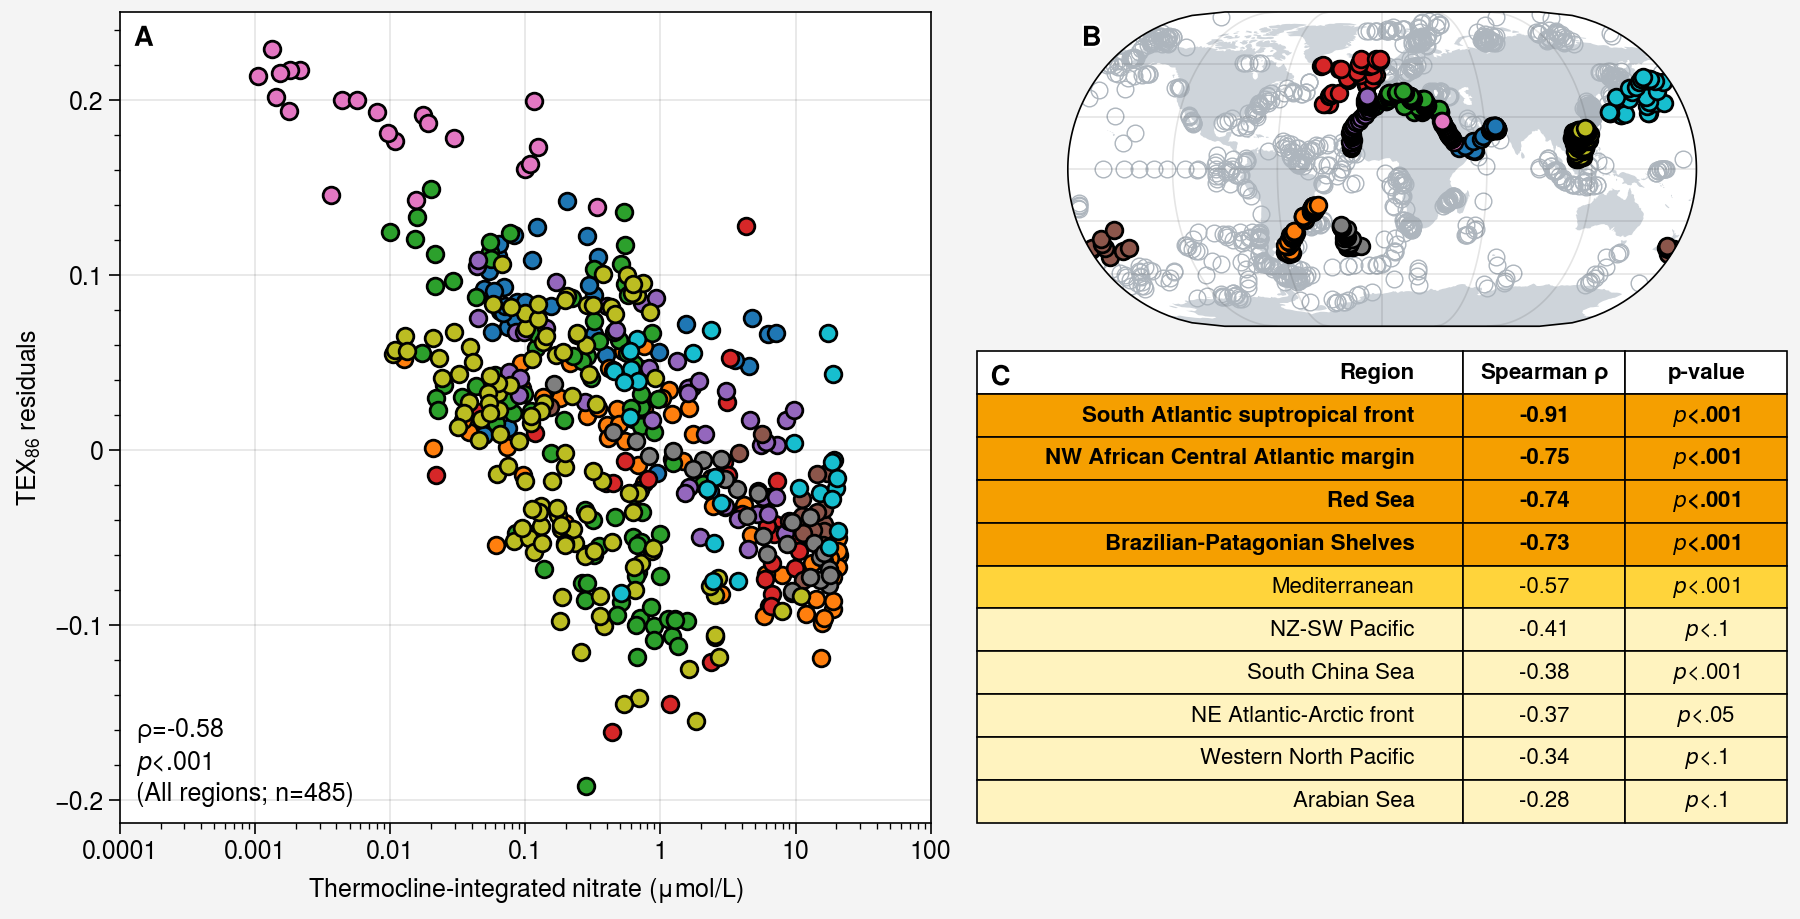

In [31]:
array = [
    [1,1,2,2],
    [1,1,3,3]
]
### param for plotting
optimal_pval_cutoff = 0.1
nitrate_cutoff = 100

fig, axs = plot.subplots(array,share=0,
                         proj=(None,'eck3',None),
                         hratios=[1,1.5],
                         width=9)
plot_gridded_data = gridded_coretop_ds[['lat','lon','thermocl_depthIntg_T','thermocl_depthIntg_nitrate',
                                        'tex_median','tex_residuals','tex_std','region_ID']].to_dataframe().dropna(subset=['region_ID']).reset_index()
plot_gridded_data['regionName'] = plot_gridded_data['region_ID'].map(regionID_to_regionName_dict)
plot_gridded_data['regionName'] = plot_gridded_data['regionName'].replace({
    'Eastern Indian Ocean (Offshore Indonesia)' : 'Indonesian Offshore',
    'Northern Pacific':'Western North Pacific',
    'Eastern South America Offshore':'Brazilian-Patagonian Shelves',
    'South Atlantic Gyre':'South Atlantic suptropical front',
    'Tropical West African Offshore':'NW African Central Atlantic margin',
    'North Atlantic':'NE Atlantic-Arctic front',
})

plot_gridded_data = plot_gridded_data[plot_gridded_data['thermocl_depthIntg_nitrate']<nitrate_cutoff]

ax = axs[1]
ax.format(
    land=True, landcolor='gray4',landzorder=0,
)
grouped = plot_gridded_data.groupby('regionName')

#### calculate rho and pval between tex_residuals and thermocl_depthIntg_nitrate by regions
rho_list = []
pval_list = []
region_name_list = []
for name, group in grouped:
    reg_data = group[['thermocl_depthIntg_nitrate','tex_residuals']].dropna()
    if len(reg_data)<10:
        continue
    else:
        rho, pval = spearmanr(reg_data['thermocl_depthIntg_nitrate'],reg_data['tex_residuals'])
        rho_pearson, pval_pearson = pearsonr(reg_data['thermocl_depthIntg_nitrate'],reg_data['tex_residuals'])
        region_name_list.append(name)
        rho_list.append(rho)
        pval_list.append(pval)

### build a dataframe to sort by rho
rho_df = pd.DataFrame({'regionName':region_name_list,
                       'rho':rho_list,
                       'pval':pval_list})

sig_regions_ = rho_df[((rho_df['pval']<optimal_pval_cutoff) 
                       & (rho_df['rho']<0))]
                       
sig_regions_ = rho_df[((rho_df['pval']<optimal_pval_cutoff)
                       & (rho_df['rho']<0))][rho_df['regionName'].isin([
                           'Weddell Sea','Arctic Ocean','Drake Passage',
                           'Kara Sea','Greenland Sea',
                           'Laptev Sea',
                           'Sea of Okhotsk',
                        #    'Eastern South America Offshore_far'
                           ])==False]
sig_regions_color_dict = dict(zip(sig_regions_['regionName'],plot.get_colors('tab10',len(sig_regions_))))


for name, group in grouped:
    ### check rho and pval of each region
    if name not in sig_regions_['regionName'].unique():
        ax.scatter(group['lon'],group['lat'],
                    c='none',
                    mec='gray5',mew=0.5,
                    label=name,
                    zorder=1)
    else:
        rho_ = rho_df[rho_df['regionName']==name]['rho'].values[0]
        pval_ = rho_df[rho_df['regionName']==name]['pval'].values[0]
        
        if (pval_<optimal_pval_cutoff 
            and (rho_<0)
            and name!='Weddell Sea'
            and name!='Arctic Ocean'
            and name!='Drake Passage'
            and name!='Kara Sea'
            and name!='Greenland Sea'
            and name!='Laptev Sea'
            and name!='Sea of Okhotsk'
            # and name!='Eastern South America Offshore_far'
            ):
            ax.scatter(group['lon'],group['lat'],
                    c=sig_regions_color_dict.get(name,'gray5'),
                    mec='k',mew=1,
                    label=name,
                    zorder=2)

            

ax = axs[0]
sig_plot_data = plot_gridded_data[plot_gridded_data['regionName'].isin(sig_regions_['regionName'])]
grouped = sig_plot_data.groupby('regionName')   
for name, group in grouped:
    ### plot data
    ax.scatter(group['thermocl_depthIntg_nitrate'],group['tex_residuals'],
                c=sig_regions_color_dict.get(name,'gray5'),
                mec='k',mew=1,
                label=name,
                zorder=2)
    
### ols regression of all significant regions
reg_data = sig_plot_data[['thermocl_depthIntg_nitrate','tex_residuals']].dropna()
reg_data['Log10_nitrate'] = np.log10(reg_data['thermocl_depthIntg_nitrate'])
ols = LinearRegression()
XX = reg_data['Log10_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
# ax.plot(10**XX_sample,yy_pred,c='deep red')
### spearman rho and pval
rho, pval = spearmanr(reg_data['thermocl_depthIntg_nitrate'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
ax.text(0.02,0.02,f'$\\rho$={rho:.2f}\n{pval_label}\n(All regions; n={len(reg_data)})',
        transform=ax.transAxes,
        ha='left',va='bottom')

### orthoganal distance regression 
X = reg_data['Log10_nitrate']
y = reg_data['tex_residuals']
covx = np.cov(X)
covy = np.cov(y)
odr_dat = scipy.odr.Data(X,y)
def linear_func(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
odr_func = scipy.odr.Model(linear_func)
odr = scipy.odr.ODR(odr_dat,odr_func,beta0=[-2.,0.2])
out = odr.run()
slope = out.beta[0]
intercept = out.beta[1]
X_pred = np.linspace(X.min(),X.max(),100)
y_pred = linear_func(out.beta,X_pred)
# ax.plot(10**X_pred,y_pred,c='k',ls='--',lw=2,label='ODR fit')

ax.format(
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals',
    xlim=(1e-4,1e2),
    xscale='log',
)

axs.format(
    abc=True,abcstyle='A',abcloc='ul',
)

### plot a table reporting rho and pval of significant regions
table_ax = axs[2]
table_ax.axis('off')
table_data = sig_regions_[['regionName','rho','pval']]

### formatted values to be displayed in the table as 4 significant figures
table_data['rho'] = table_data['rho'].apply(lambda x: f'{x:.2f}')
table_data['pval'] = table_data['pval'].apply(lambda x: f'{x:.4f}')
table_data['pval_labels'] = table_data['pval'].apply(lambda x: label_pvalues(float(x)))
table_data = table_data.rename(columns={'regionName':'Region',
                                        'rho':'Spearman $\\rho$',
                                        'pval_labels':'p-value'})

table_data2 = table_data[['Region','Spearman $\\rho$','p-value']].sort_values(by='Spearman $\\rho$',ascending=False).copy()
### color cell with rho < -0.7
### set header text bold
### set header background color
table = table_ax.table(cellText=table_data2.values,
                colLabels=table_data2.columns,
                loc='top',
                bbox=[0,0,1,1],
                colWidths=[0.6,0.2,0.2],
                cellColours=np.reshape(
                    ['yellow7' if float(rho)<-0.7 
                     else 'yellow4' if float(rho)<-0.5 
                     
                     else 'yellow1' 
                     for rho in table_data2['Spearman $\\rho$']]*3,(3,len(table_data))).T
                )
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.get_text().set_fontweight('bold')
    if col == 0:
        ### set right alignment for the first column
        cell.get_text().set_ha('right')
    else:
        cell.get_text().set_ha('center')
        if col == 1 and row > 0:
            ### set font weight as bold for row with rho < -0.7
            if float(cell.get_text().get_text())<-0.7:
                table[(row,0)].get_text().set_fontweight('bold')
                table[(row,1)].get_text().set_fontweight('bold')                
                table[(row,2)].get_text().set_fontweight('bold')
    
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.5, 1.5)

# ### plot vertical line for nitrate cutoff
# ax = axs[0]
# ax.axvline(nitrate_cutoff,c='gray5',ls='--',lw=1,zorder=0)
# ### shaded area for nitrate > nitrate_cutoff
# ax.fill_betweenx(ax.get_ylim(),nitrate_cutoff,ax.get_xlim()[1],color='gray5',alpha=0.2,zorder=0)
# ### add vertical text say "high nutrient" region in the plot
# ax.text(nitrate_cutoff+3,0.5,'High nutrient',
#         transform=ax.get_xaxis_transform(),
#         ha='center',va='center',rotation=90,
#         fontweight='bold',
#         fontsize=20,
#         fontcolor='gray5')

fpath = fr'{local_github_path}/figures/'
fname = 'gridded_regional_nitrate_effect_sig_regions.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight')

In [32]:
### round rho to 2 decimal places and pval to 4 decimal places
rho_df['rho_labels'] = rho_df['rho'].apply(lambda x: f'{x:.2f}')
rho_df['pval_labels'] = rho_df['pval'].apply(lambda x: f'{x:.4f}')
rho_df[rho_df['rho']<0].sort_values(by='pval')[['regionName','rho_labels','pval_labels']]

,regionName,rho_labels,pval_labels
7,Brazilian-Patagonian Shelves,-0.73,0.0000
30,South Atlantic suptropical front,-0.91,0.0000
19,Mediterranean,-0.57,0.0000
22,NW African Central Atlantic margin,-0.75,0.0000
31,South China Sea,-0.38,0.0000
26,Red Sea,-0.74,0.0001
10,Drake Passage,-0.39,0.0108
36,Weddell Sea,-0.68,0.0153
21,NE Atlantic-Arctic front,-0.37,0.0450
2,Arctic Ocean,-0.49,0.0664


In [33]:
# ### reverse dict key and values
# regionName_to_regionID_dict = {v:k for k,v in regionID_to_regionName_dict.items()}


# plot_gridded_data = gridded_coretop_ds[['lat','lon','thermocl_depthIntg_T','thermocl_depthIntg_nitrate',
#                                         'tex_median','tex_residuals',
#                                         'tex_std','region_ID']].to_dataframe().reset_index()
# plot_gridded_data['regionName'] = plot_gridded_data['region_ID'].map(regionID_to_regionName_dict)
# grouped = plot_gridded_data.groupby('regionName')

# #### calculate rho and pval between tex_residuals and thermocl_depthIntg_nitrate by regions
# rho_list = []
# pval_list = []
# region_name_list = []
# for name, group in grouped:
#     reg_data = group[['thermocl_depthIntg_nitrate','tex_residuals']].dropna()
#     rho, pval = spearmanr(reg_data['thermocl_depthIntg_nitrate'],reg_data['tex_residuals'])
#     region_name_list.append(name)
#     rho_list.append(rho)
#     pval_list.append(pval)

# ### build a dataframe to sort by rho
# rho_df = pd.DataFrame({'regionName':region_name_list,
#                        'rho':rho_list,
#                        'pval':pval_list})

# optimal_pval_cutoff = 0.1
# sig_regions_ = rho_df[((rho_df['pval']<optimal_pval_cutoff) 
#                        & (rho_df['rho'].between(-0.5,0)))][rho_df['regionName'].isin(['Weddell Sea','Kara Sea'])==False]


# fig, axs = plot.subplots(ncols=3,
#                          nrows=len(sig_regions_),
#                          width=12,proj=('robin','robin',None)*len(sig_regions_),
# )

# for i in range(len(sig_regions_)):
#     sel_region_ID = regionName_to_regionID_dict.get(sig_regions_.iloc[i]['regionName'])
    
#     plot_gridded_sel_sigRegion = gridded_coretop_ds.where(gridded_coretop_ds['region_ID']==sel_region_ID)
#     plot_gridded_sel_sigRegion
#     nonnan_idx = ~np.isnan(plot_gridded_sel_sigRegion['thermocl_depthIntg_nitrate'])
#     plot_data = plot_gridded_sel_sigRegion.where(nonnan_idx).to_dataframe().dropna(subset=['thermocl_depthIntg_nitrate']).reset_index()
#     plot_lat = plot_data['lat']
#     plot_lon = plot_data['lon']
#     plot_color = plot_data['thermocl_depthIntg_nitrate']

#     ax = axs[i,0]
#     sc = ax.scatter(plot_lon,plot_lat,c=plot_color,
#                     levels=[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2],
#                     cmap='matter_r',s=10)
#     ax.colorbar(sc,
#                 loc='b',
#                 label='Thermocline-integrated nitrate ($\mu$mol/L)')
    
#     ax.format(
#         land=True, landcolor='gray4',landzorder=0,
#         latlim=(plot_lat.min()-5,plot_lat.max()+5),
#         lonlim=(plot_lon.min()-5,plot_lon.max()+5),
#     )

#     ax = axs[i,1]
#     plot_lat = plot_data['lat']
#     plot_lon = plot_data['lon']
#     plot_color = plot_data['tex_residuals']
#     m = ax.scatter(plot_lon,plot_lat,c=plot_color,
#                     cmap='balance',s=10)
#     ax.colorbar(m,
#                 loc='b',
#                 label='TEX$_{86}$ residuals')
#     ax.format(
#         land=True, landcolor='gray4',landzorder=0,
#         latlim=(plot_lat.min()-5,plot_lat.max()+5),
#         lonlim=(plot_lon.min()-5,plot_lon.max()+5),
#     )

#     ax = axs[i,2]

#     nonnan_idx2 = (~np.isnan(plot_gridded_sel_sigRegion['thermocl_depthIntg_nitrate'])&(~np.isnan(plot_gridded_sel_sigRegion['tex_residuals'])))
#     plot_data = plot_gridded_sel_sigRegion.where(nonnan_idx2).to_dataframe().dropna(subset=['thermocl_depthIntg_nitrate']).reset_index()
#     plot_x = plot_data['thermocl_depthIntg_nitrate']
#     plot_y = plot_data['tex_residuals']
#     ax.scatter(plot_x,plot_y,c='k',s=10)
#     ax.format(
#         xscale='log',
#     )

#     ### identify fliers in the plot using machine learning
#     from sklearn.ensemble import IsolationForest
#     from sklearn.covariance import EllipticEnvelope
#     from sklearn.svm import OneClassSVM
#     from sklearn.preprocessing import StandardScaler

#     plot_data = plot_data[['thermocl_depthIntg_nitrate','tex_residuals','lat','lon']].dropna()
#     plot_data['Log10_nitrate'] = np.log10(plot_data['thermocl_depthIntg_nitrate'])
#     plot_data['Log10_nitrate'] = plot_data['Log10_nitrate'].replace([-np.inf,np.inf],np.nan)
#     plot_data = plot_data.dropna(how='any',subset=['thermocl_depthIntg_nitrate','tex_residuals','Log10_nitrate'])
#     plot_data2 = plot_data[['Log10_nitrate','tex_residuals','lat','lon']].dropna()
#     X = plot_data2[['Log10_nitrate','tex_residuals']].values
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
#     clf = OneClassSVM(nu=0.03, kernel="rbf", gamma='auto')
#     clf.fit(X_scaled)
#     y_pred = clf.predict(X_scaled)
#     plot_data2['outlier'] = y_pred
#     plot_data_outliers = plot_data2[plot_data2['outlier']==-1]
#     plot_data_inliers = plot_data2[plot_data2['outlier']==1]

#     ax.scatter(10**plot_data_outliers['Log10_nitrate'],plot_data_outliers['tex_residuals'],
#                   c='r',s=10,label='Outliers')

#     plot_lat_outliers = plot_data_outliers['lat']
#     plot_lon_outliers = plot_data_outliers['lon']
#     axs[i,0:2].scatter(plot_lon_outliers,plot_lat_outliers,
#                        marker='o',facecolor='none',edgecolor='dark red',s=30)

## Fig. 4: Paleo-applications